Step 1: Merge Features and Target

In [2]:
import pandas as pd

# Load the raw training data and target labels
train_df = pd.read_csv('../data/train.csv')  # adjust path if needed
labels_df = pd.read_csv('../data/train_labels.csv')

# Extract only the target we care about: target_2
target_df = labels_df[['date_id', 'target_2']].copy()

# Merge the features with the target
merged_df = pd.merge(train_df, target_df, on='date_id', how='left')


Step 2: Align Target with Future Value (Shift by -1)

In [3]:
# Shift the target up by 1 day to align with today’s features
merged_df['target_2_shifted'] = merged_df['target_2'].shift(-1)

# Drop last row (where shifted target becomes NaN)
merged_df = merged_df.dropna(subset=['target_2_shifted'])


Step 3: Preview That It Worked

In [4]:
# Preview a few rows of relevant columns
merged_df[['date_id', 'LME_CA_Close', 'LME_ZS_Close', 'target_2', 'target_2_shifted']].head(10)


,date_id,LME_CA_Close,LME_ZS_Close,target_2,target_2_shifted
0,0,7205.0,3349.0,-0.004675,-0.007052
1,1,7147.0,3327.0,-0.007052,-0.008934
2,2,7188.5,3362.0,-0.008934,0.011943
3,3,7121.0,3354.0,0.011943,0.006856
4,4,7125.0,3386.0,0.006856,-0.016626
5,5,7102.0,3335.0,-0.016626,-0.003542
6,6,7153.0,3336.0,-0.003542,0.002360
7,7,7140.5,3386.0,0.002360,-0.013058
8,8,7110.0,3383.5,-0.013058,0.004692
9,9,7210.0,3423.0,0.004692,0.003432


Step 4: Plot the Target Over Time

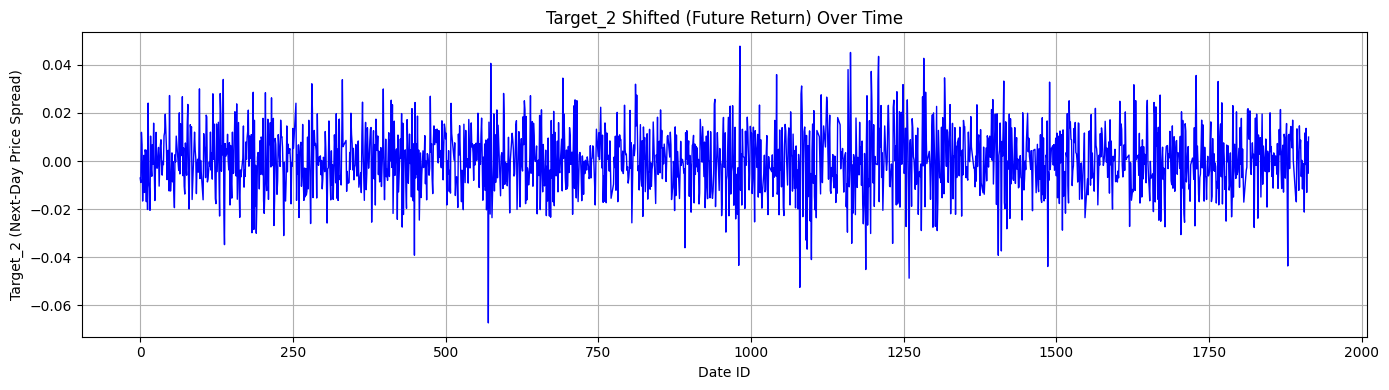

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt


# Plot future target over time
plt.figure(figsize=(14, 4))
plt.plot(merged_df['date_id'], merged_df['target_2_shifted'], color='blue', linewidth=1)
plt.title("Target_2 Shifted (Future Return) Over Time")
plt.xlabel("Date ID")
plt.ylabel("Target_2 (Next-Day Price Spread)")
plt.grid(True)
plt.tight_layout()
plt.show()


Distribution plot:

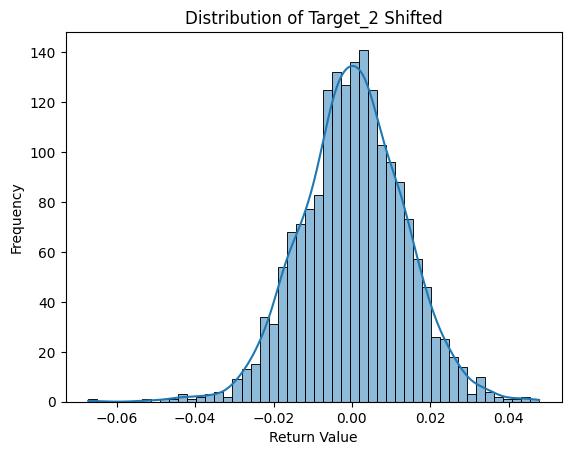

In [6]:
sns.histplot(merged_df['target_2_shifted'], kde=True, bins=50)
plt.title("Distribution of Target_2 Shifted")
plt.xlabel("Return Value")
plt.ylabel("Frequency")
plt.show()


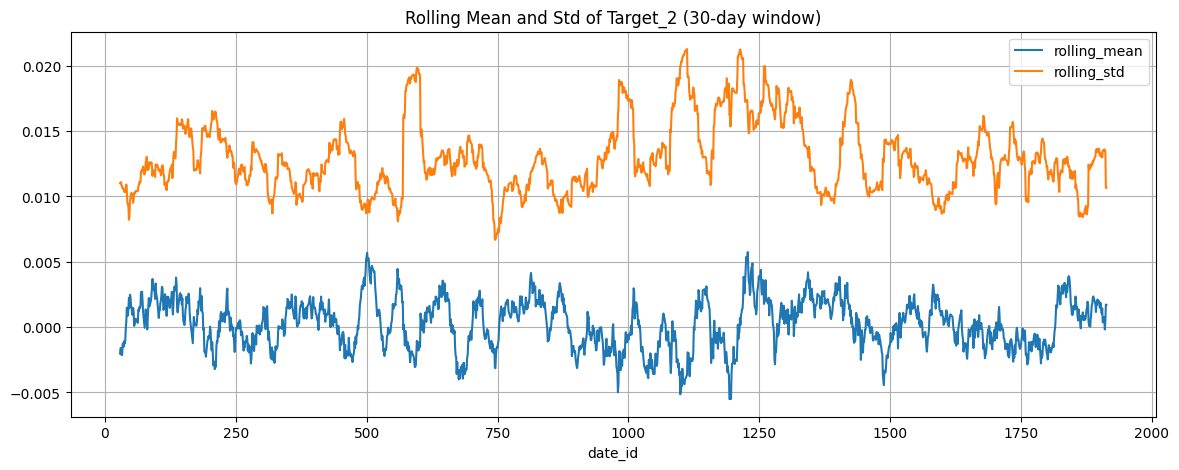

In [7]:
merged_df['rolling_mean'] = merged_df['target_2_shifted'].rolling(30).mean()
merged_df['rolling_std'] = merged_df['target_2_shifted'].rolling(30).std()

merged_df[['date_id', 'rolling_mean', 'rolling_std']].plot(x='date_id', figsize=(14,5))
plt.title("Rolling Mean and Std of Target_2 (30-day window)")
plt.grid(True)
plt.show()


In [8]:
# Step: Missing values per feature
missing_counts = merged_df.isna().sum().sort_values(ascending=False)
missing_counts.head(10)  # Preview top 10 features with the most NaNs


US_Stock_GOLD_adj_open                1594
US_Stock_GOLD_adj_low                 1594
US_Stock_GOLD_adj_high                1594
US_Stock_GOLD_adj_close               1594
US_Stock_GOLD_adj_volume              1594
JPX_Gold_Standard_Futures_Open         109
JPX_Platinum_Mini_Futures_Open         109
JPX_Platinum_Standard_Futures_Open     109
JPX_RSS3_Rubber_Futures_Open           109
JPX_Gold_Mini_Futures_High             109
dtype: int64

In [9]:
# Step: Detect constant (zero-variance) features
nunique = merged_df.nunique()
constant_cols = nunique[nunique <= 1].index.tolist()
constant_cols[:10]  # Show a few if they exist


[]

In [10]:
# Step: Find strongest features (by absolute correlation with next-day target)
correlation_with_target = (
    merged_df.drop(columns=['target_2', 'date_id'])
    .corrwith(merged_df['target_2_shifted'])
    .dropna()
    .sort_values(key=lambda x: x.abs(), ascending=False)
)

correlation_with_target.head(10)


target_2_shifted            1.000000
rolling_mean                0.160402
US_Stock_GOLD_adj_volume   -0.136075
US_Stock_OKE_adj_volume    -0.059504
US_Stock_IAU_adj_volume    -0.047202
US_Stock_VTV_adj_volume    -0.045397
US_Stock_GDX_adj_volume    -0.040645
US_Stock_FXI_adj_volume    -0.035463
US_Stock_STLD_adj_volume   -0.034521
US_Stock_GOLD_adj_close    -0.034148
dtype: float64

In [11]:
# Final export: save just the columns we'll engineer from
cols_to_keep = ['date_id', 'LME_CA_Close', 'LME_ZS_Close', 'target_2_shifted']
base_df = merged_df[cols_to_keep].copy()

# Export to CSV for next stage
base_df.to_csv('../data/base_target2_data.csv', index=False)
